<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Material_Element_Detection_in_Muon_Spectroscopy_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Ag Detection by Muon Spectroscopy

In this notebook, we attempt to solve a real problem in physics using a fully connected DNN.


The data in this example is generated from simulated muon spectroscopy experiments. First the data was generated for each individual element by simulating the spectral emission lines of that element. Then for the mixed compounds the different elemental spectra were mixed in proportion to how much of that element is present in the compound.


The aim of this work is to train a neural network to detect the presence of Ag.

In [9]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [3]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'muon-data')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/muon-data/"
files_to_download = ["ag-muon-data-tight.pkl"]

In [4]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The raw data, which include the constituent elements and the Muon spectra of the samples, are stored in the pickle file `muon-data/ag-muon-data-tight.pkl`. We load this file into a `pandas` dataframe and take a quick look.

In [10]:
# read data
df = pd.read_pickle(join(data_path, 'muon-data/ag-muon-data-tight.pkl'))
#print dimensions
print('Number of samples in the dataset: %d' % len(df['Spectra']))
print('Length of spectra for each sample: %d' % len(df['Spectra'][0]))

# print the first few data
df.head(n=5)

Number of samples in the dataset: 138613
Length of spectra for each sample: 1000


,Elements,oh,c,Spectra
8877,"[Si, Fe, Sb, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 132.19327401887..."
88555,"[Sb, Fe, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.91719527298..."
111153,"[Si, Sb]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 108.04741040971..."
27279,"[Fe, Cu, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.84704457348..."
26419,"[Si, Fe]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.82180543319..."


In the above table, the `Elements` and the `Spectra` columns show respectively the elements and the spectra of the samples. There are 138,613 samples in the dataset, and each spectrum is a series of 1000 positive reals.

To get a feel for the complexity of picking out signals with Ag in multinary samples, we can plot some random spectra for three representative cases:

* no Ag
* pure Ag
* Ag-Si binary

Note that we are plotting only the first part of each spectrum. Change `[0:150]` to `[:]` to show the full spectra.

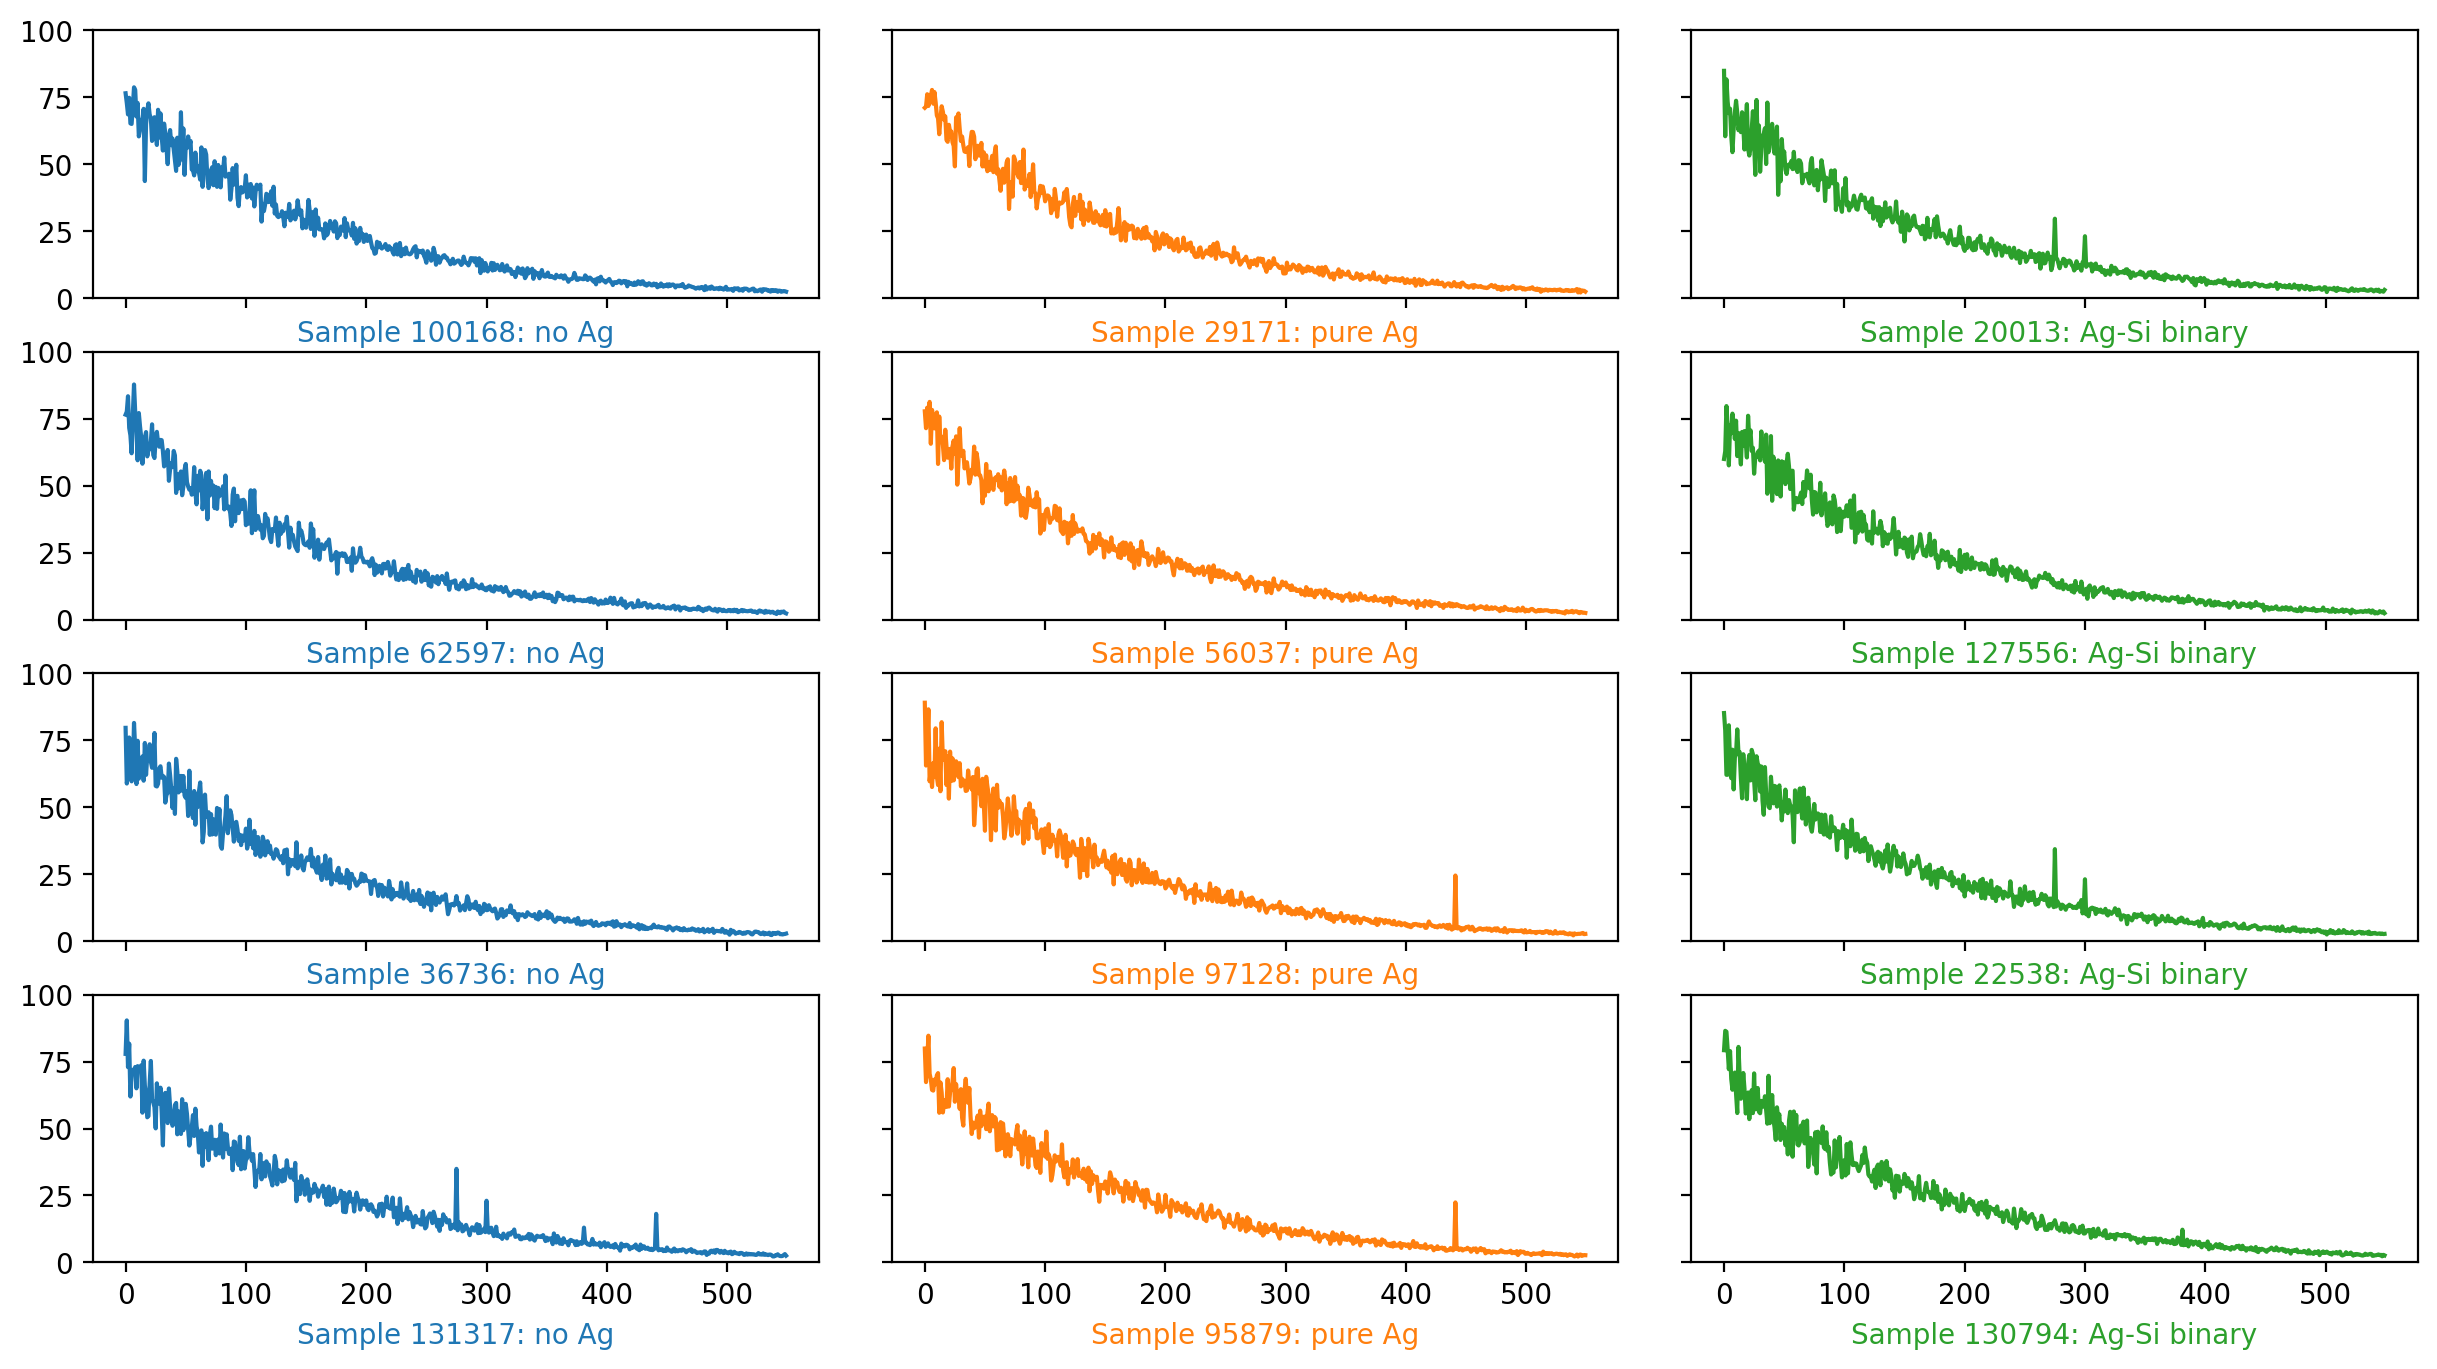

In [11]:
# conditions to select data
conditions = [
# no Ag
('no Ag', np.where(['Ag' not in elements for elements in df['Elements']])[0]),
# pure Ag
('pure Ag', np.where([['Ag'] == elements for elements in df['Elements']])[0]),
# Ag-Si
('Ag-Si binary', np.where([['Ag', 'Si'] == elements for elements in df['Elements']])[0])
]

# plot
ncond = len(conditions)
nplot = 4 # number of plots per condition
fig, axs = plt.subplots(nplot, ncond, dpi=200, figsize=(ncond * 5, nplot * 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.1, hspace=.2)
for icond, cond in enumerate(conditions):
    for iplot, idata in enumerate(np.random.choice(cond[1], nplot)):
        axs[iplot, icond].plot(df['Spectra'][idata][150:700], c='C%d' % icond)
        axs[iplot, icond].set_xlabel('Sample %d: %s' % (idata, cond[0]), c='C%d' % icond)
        axs[iplot, icond].set_ylim(0, 100)

### Prepare training data

The input data for our network will be the `Spectra` column, and we can use the `to_list()` method to convert it to a numpy array. The output data for our network will be a binary-valued one-hot vector: 0 for no Ag in the sample and 1 otherwise. One-hot encoding can be achieved by a simple for-loop. Also, it is important to normalise each spectrum between 0 and 1.

In [12]:
###### input ######
# convert the 'Spectra' column to numpy
x_train = np.array(df['Spectra'].to_list())
# normalise each spectrum to [0, 1]
x_train /= np.max(x_train, axis=1)[:, np.newaxis]

###### output ######
# one-hot encoding: whether Ag is in 'Elements'
y_train = np.array(['Ag' in elements for elements in df['Elements']]).astype(int)

# print data shapes
print("Shape of input: %s" % str(x_train.shape))
print("Shape of output: %s" % str(y_train.shape))

Shape of input: (138613, 1000)
Shape of output: (138613,)


---

# 2. Build the network

In this case, the output is whether the data includes 'Ag' (1) or not (0). Therefore, the size of the outout of the last dense layer is 1. Then, we use 'binary_Crossentropy' and will see 'accuracy' while training the model.



**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```
    
</p>
</details>


In [13]:
# define the model
model = Sequential()
model.add(Input(shape=(1000,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,121 (254.38 KB)

 Trainable params: 65,121 (254.38 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Since we have not separated a subset of data for validation, we can pass `validation_split=0.2` to `model.fit()`, which then will use the *final* 20% of the dataset for validation. Let us do 10 epochs first.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# train the model

training_history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                             validation_split=0.2)
```
    
</p>
</details>

In [14]:
# train the model

training_history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                             validation_split=0.2)

Epoch 1/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9272 - loss: 0.2666 - val_accuracy: 0.9254 - val_loss: 0.2647
Epoch 2/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9272 - loss: 0.2611 - val_accuracy: 0.9254 - val_loss: 0.2626
Epoch 3/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9272 - loss: 0.2593 - val_accuracy: 0.9254 - val_loss: 0.2592
Epoch 4/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9272 - loss: 0.2562 - val_accuracy: 0.9254 - val_loss: 0.2508
Epoch 5/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9272 - loss: 0.2406 - val_accuracy: 0.9301 - val_loss: 0.2170
Epoch 6/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9343 - loss: 0.1876 - val_accuracy: 0.9671 - val_loss: 0.1279
Epoch 7/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9579 - loss: 0.1213 - val_accuracy: 0.9746 - val_loss: 0.0976
Epoch 8/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9680 - loss: 0.0958 - 

---

# 3. Analyse results

### Plot training history

For convenience, we define a function to plot a training history:

In [15]:
# a function to plot training history
def plot_history(training_history):
    # plot accuracy
    plt.figure(dpi=100, figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history[acc_str], label='Accuracy on training data')
    plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
    plt.legend()
    plt.title("Accuracy")

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Loss on training data')
    plt.plot(training_history.history['val_loss'], label='Loss on test data')
    plt.legend()
    plt.title("Loss")
    plt.show()

Now, plot the training history of the current model. They will look bizarre at this stage, as explained in the forthcoming section.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# plot training history
plot_history(training_history)
```
    
</p>
</details>

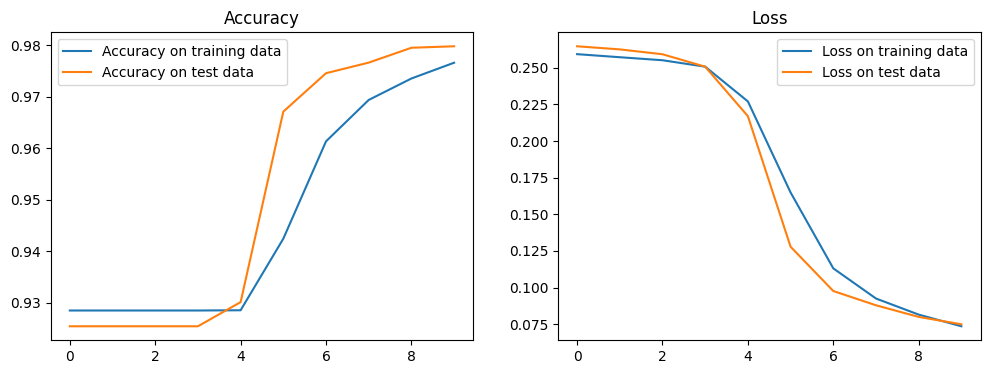

In [16]:
# plot training history
plot_history(training_history)

---

# 4. Exercise

## Class imbalance

In the above history plot, notice how the accuracy of the model converges to a high value very quickly (>90% at the end of the first epoch). Such an odd history indicates that something could be wrong within our dataset.

### Data distribution

Let us inspect the distribution of the data using `plt.hist(y_train)`, paying special attention to the validation part (the final 20%).

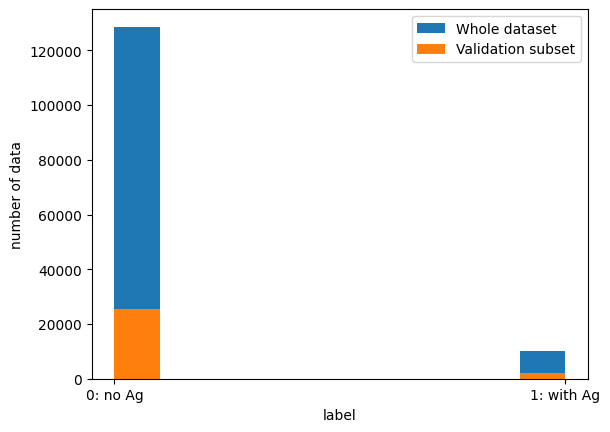

In [17]:
# plot distribution of data
plt.figure(dpi=100)
plt.hist(y_train, label='Whole dataset')
plt.hist(y_train[-len(y_train)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

The histograms show that our dataset is dominated by samples labelled 0 or "no Ag", which account for over 95% of the data. Thus, if the model simply learns to *guess* "no Ag" in every sample, it can achieve 95% accuracy without learning anything meaningful. This problem is known as **class imbalance**.

To avoid this, we must balance the classes. There are a number of strategies we can take:

* Upsample the minority class;
* Downsample the majority class;
* Change the performance metric.

The best available option for our problem is to downsample the majority class, which can be easily achieved with `numpy`:

In [18]:
# find original indices of 0 ('no Ag') and 1 ('with Ag')
id_no_Ag = np.where(y_train == 0)[0]
id_with_Ag = np.where(y_train == 1)[0]

# downsample 'no Ag' to the number of 'with Ag' by np.random.choice
id_no_Ag_downsample = np.random.choice(id_no_Ag, len(id_with_Ag))

# concatenate 'with Ag' and downsampled 'no Ag'
id_downsample = np.concatenate((id_with_Ag, id_no_Ag_downsample))

# shuffle the indices because they are ordered after concatenation
np.random.shuffle(id_downsample)

# finally get the balanced data
x_train_balanced = x_train[id_downsample]
y_train_balanced = y_train[id_downsample]

Re-exam the histograms of the balanced dataset after downsampling the majority:

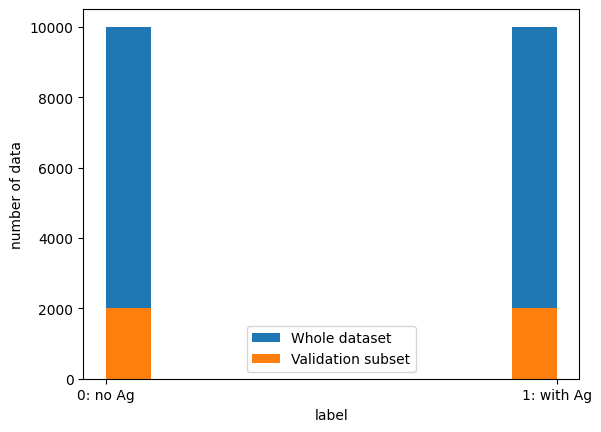

In [19]:
# plot distribution of downsampled data
plt.figure(dpi=100)
plt.hist(y_train_balanced, label='Whole dataset')
plt.hist(y_train_balanced[-len(y_train_balanced)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

### Re-train the model

Now we can re-train the model with the balanced dataset. Simply change `x_train` and `y_train` to `x_train_balanced` and `y_train_balanced` in `model.fit()` and repeat all the steps in [1. Try out a network](#1.-Try-out-a-network). Note that, to avoid the influence of the initial model state (weights and biases) left by the previous training (such as the one trained with the imbalanced dataset), we have to first re-define and re-compile the model before calling `model.fit()`. A larger `epochs` can be used because we now have much fewer data.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
tic = time.time()
training_history_balanced = model.fit(x_train_balanced, y_train_balanced,
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.time() - tic))

# plot training history
plot_history(training_history_balanced)
```
    
</p>
</details>

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4972 - loss: 0.6949 - val_accuracy: 0.5013 - val_loss: 0.6930
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5106 - loss: 0.6931 - val_accuracy: 0.5182 - val_loss: 0.6928
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5125 - loss: 0.6930 - val_accuracy: 0.5290 - val_loss: 0.6926
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5134 - loss: 0.6928 - val_accuracy: 0.5385 - val_loss: 0.6925
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5159 - loss: 0.6926 - val_accuracy: 0.5470 - val_loss: 0.6923
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5178 - loss: 0.6924 - val_accuracy: 0.5335 - val_loss: 0.6920
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5191 - loss: 0.6922 - val_accuracy: 0.5330 - val_loss: 0.6917
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5230 - loss: 0.6919 - val_accuracy: 0.5138 - 

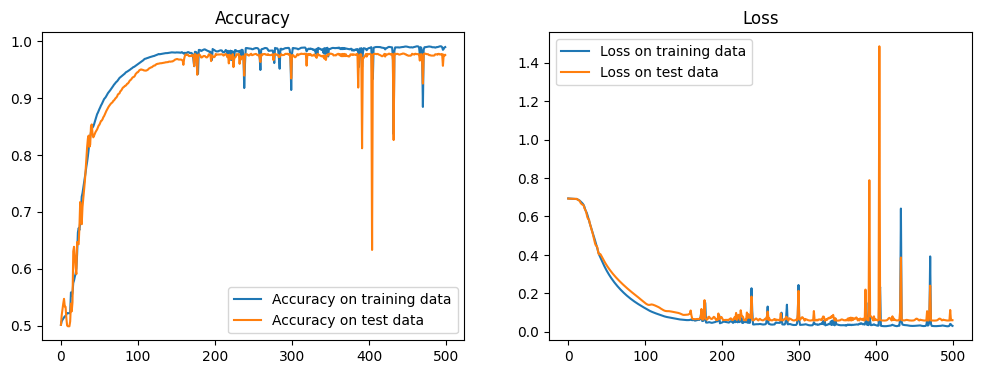

In [23]:
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Input(shape=(1000,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
tic = time.time()
training_history_balanced = model.fit(x_train_balanced, y_train_balanced,
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.time() - tic))

# plot training history
plot_history(training_history_balanced)

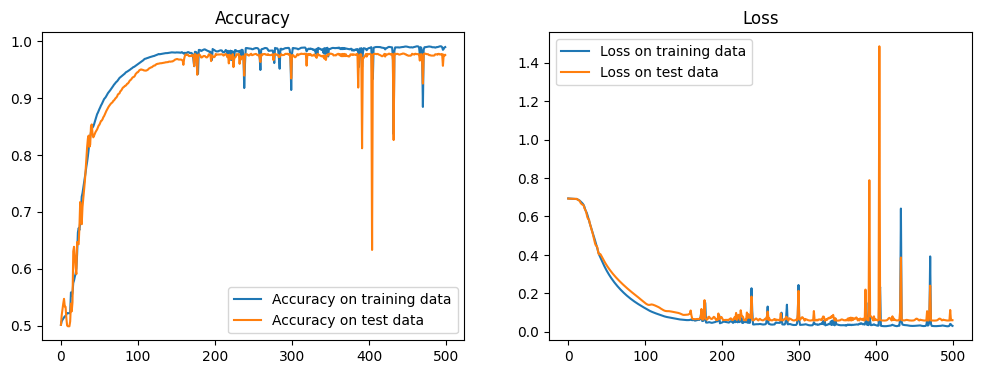

In [24]:
# plot training history
plot_history(training_history_balanced)

### Early stopping

The droput has brought the training and validation losses closer to one another. However we also see that there are large oscillations in the validation performance. This is realted to the rather small training and validation set sizes. How can we make sure that we recover the model with the best performance on validation?

We can use a **callback** to tell the algorithm to save the model every time there is a new best validation loss. We can then also tell the training algorithm to cease if the validation loss has not improved for _n_ steps; below we set up a callback to monitor the `val_accuracy` and to stop if this has not improved for 20 steps, then restore the weights of the best model.

```
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
```

The callbacks are then specified as a list of all callbacks you defined and passed to the `fit` function _via_ the keyword `callbacks`.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the callback
callback = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# re-train the model
tic = time.time()
training_history_balanced = model.fit(x_train_balanced, y_train_balanced,
                                      epochs=500, batch_size=256, validation_split=0.2,
                                      callbacks=[callback])
print('run time: {:5.3f} s'.format(time.time() - tic))
    
# plot training history
plot_history(training_history_balanced)
```
    
</p>
</details>

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5029 - loss: 0.6940 - val_accuracy: 0.4843 - val_loss: 0.6932
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5084 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4964 - loss: 0.6932 - val_accuracy: 0.5013 - val_loss: 0.6931
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4928 - loss: 0.6933 - val_accuracy: 0.5113 - val_loss: 0.6931
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4968 - loss: 0.6932 - val_accuracy: 0.5013 - val_loss: 0.6931
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4958 - loss: 0.6932 - val_accuracy: 0.5163 - val_loss: 0.6931
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5042 - loss: 0.6931 - val_accuracy: 0.5013 - val_loss: 0.6931
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.5013 - 

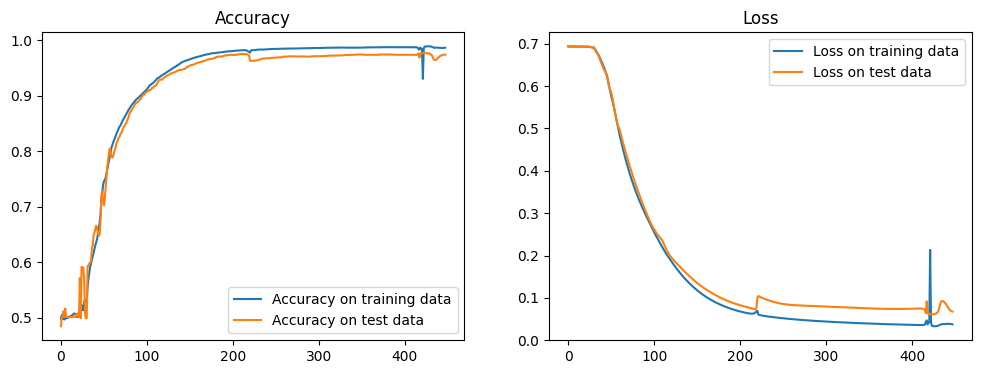

In [26]:
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Input(shape=(1000,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the callback
callback = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# re-train the model
tic = time.time()
training_history_balanced = model.fit(x_train_balanced, y_train_balanced,
                                      epochs=500, batch_size=256, validation_split=0.2,
                                      callbacks=[callback])
print('run time: {:5.3f} s'.format(time.time() - tic))

# plot training history
plot_history(training_history_balanced)

---

## More exercises

Build a DNN to detect the presence of all the elements. To do this, you may go through the following steps:

1. Find all the elements appearing in the dataset; the answer will be `['Zn', 'Sb', 'Si', 'Fe', 'Ag', 'Cu', 'Bi']`.
2. Balance the dataset: if one of the elements appears much less times than the others, it is better to ignore it. Doing everything correctly, you will find the number of samples containing each element as shown in the following table. Therefore, we may ignore Ag in this network.


|  Element | # Samples |
|---|---|
|Zn| 51174|  
|Sb| 51132|  
|Si| 50909|
|Fe| 50764|
|Ag| 10000|
|Cu| 50945|
|Bi| 50784|
    
3. Do one-hot encoding for the element list `['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']`; if a sample contains Fe and Sb, e.g., the one-hot vector for this sample will be `[0, 1, 0, 1, 0, 0]`.
4. Build and train a DNN (with an input size of 150 and an output size of 6) to detect the presence of the six elements.

If doing everything correctly, you will find that the overall accuracy is around 60%. However, the model is not garbage. If we evaluate the accuracy for each element, we will find that the accracy for some of elements is nearly 0 while for the others nearly 100%. This means the dataset is agnostic to these elements, which lower the overall accuracy, but the model can still be used to predict the other elements with  high accuracy.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
##################
###### data ######
##################
# output
element_list = ['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']
y_train = []
for element in element_list:
    y_train.append(np.array([element in elements for elements in df['Elements']]).astype(int))
y_train = np.transpose(np.array(y_train))

# print data shapes
print("Shape of input: %s" % str(x_train.shape))
print("Shape of output: %s" % str(y_train.shape))


###################
###### model ######
###################
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


###################
###### train ######
###################
# train the model
training_history = model.fit(x_train, y_train, epochs=100, batch_size=256,
                             validation_split=0.2)
# plot training history
plot_history(training_history)


#####################
###### predict ######
#####################
y_pred = model.predict(x_train)

# show overall accuracy and accuracy for each element
def binary_accuracy(pred, ground_truth):
    return np.where(np.abs(pred - ground_truth) < .1)[0].size / pred.size

print(f'Overall accuracy = {binary_accuracy(y_pred, y_train)}')
for i, element in enumerate(element_list):
    print(f'Accuracy for {element} = {binary_accuracy(y_pred[:, i], y_train[:, i])}')
```
    
</p>
</details>